In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plotting.paper import plot_trained_draws, plot_training_histories
from plotting.scores import show_all_loss_scores, show_loss_scores

# Experiments for different loss functions

In [4]:
show_all_loss_scores([(16, "exp1", 1), (16, "exp2", 1), (16, "exp3", 1)], True)

Loss functions \ $p$,1,2,3,4
RCL+KLD,8.281937,9.524274,8.804399,9.851355
KLD+10mmd_rbf_sum-1.0,72.807159,45.859921,66.643036,46.035511
KLD+10mmd_rbf_sum-4.0,43.161266,56.721821,53.187634,57.450008
KLD+10mmd_rbf_sum-7.0,23.615610,50.067070,43.658802,46.838760
KLD+10mmd_rbf_sum-10.0,28.775999,50.904537,73.190353,47.644955
RCL+KLD+10mmd_rbf_sum-1.0,3.726709,4.362447,3.045920,4.792714
RCL+KLD+10mmd_rbf_sum-4.0,3.737880,9.252775,6.101194,10.234677
RCL+KLD+10mmd_rbf_sum-7.0,4.368317,10.938683,7.339455,10.754557
RCL+KLD+10mmd_rbf_sum-10.0,4.229868,8.364177,4.605630,8.060596
"0.1RCL+10mmd_rqk_sum-1,0.1+KLD",8.131208,10.807848,8.484421,10.120835


Loss functions \ MMD scores,mmd_rbf_sum-1.0,mmd_rbf_sum-4.0,mmd_rbf_sum-10.0,"mmd_rqk_sum-4.0,0.25","mmd_rqk_sum-8.0,0.25","mmd_rqk_sum-4.0,1","mmd_rqk_sum-8.0,1","mmd_rqk_sum-4.0,10","mmd_rqk_sum-8.0,10","mmd_rqk_sum-4.0,100","mmd_rqk_sum-8.0,100"
RCL+KLD,0.006706,0.118825,0.121253,0.064119,0.047992,0.115005,0.076634,0.149453,0.099071,0.152699,0.102643
KLD+10mmd_rbf_sum-1.0,0.000208,0.031234,0.289387,0.417703,0.552355,0.223627,0.482512,0.096065,0.368296,0.085383,0.354068
KLD+10mmd_rbf_sum-4.0,0.000026,0.000214,0.000440,0.000795,0.001014,0.000483,0.000998,0.000227,0.000654,0.000221,0.000599
KLD+10mmd_rbf_sum-7.0,0.000065,0.000355,0.000373,0.000282,0.000261,0.000355,0.000388,0.000321,0.000418,0.000319,0.000414
KLD+10mmd_rbf_sum-10.0,0.000160,0.000773,0.000199,0.000268,0.000135,0.000428,0.000159,0.000552,0.000159,0.000573,0.000158
RCL+KLD+10mmd_rbf_sum-1.0,0.001490,0.082718,0.105517,0.050380,0.040164,0.091135,0.066160,0.117163,0.087242,0.119185,0.090627
RCL+KLD+10mmd_rbf_sum-4.0,0.000329,0.034562,0.067208,0.027718,0.024224,0.049511,0.041961,0.060420,0.057276,0.060573,0.059766
RCL+KLD+10mmd_rbf_sum-7.0,0.000640,0.035586,0.064212,0.027110,0.023314,0.048262,0.040166,0.058884,0.054732,0.059071,0.057102
RCL+KLD+10mmd_rbf_sum-10.0,0.000661,0.035751,0.063968,0.027074,0.023233,0.048269,0.039978,0.059073,0.054419,0.059298,0.056769
"0.1RCL+10mmd_rqk_sum-1,0.1+KLD",0.000044,0.003440,0.012520,0.004567,0.004480,0.007566,0.008211,0.007773,0.011585,0.007495,0.012108


Loss functions \,Average MMD score
RCL+KLD,0.095854
KLD+10mmd_rbf_sum-1.0,0.263712
KLD+10mmd_rbf_sum-4.0,0.000516
KLD+10mmd_rbf_sum-7.0,0.000323
KLD+10mmd_rbf_sum-10.0,0.000324
RCL+KLD+10mmd_rbf_sum-1.0,0.077435
RCL+KLD+10mmd_rbf_sum-4.0,0.043959
RCL+KLD+10mmd_rbf_sum-7.0,0.042644
RCL+KLD+10mmd_rbf_sum-10.0,0.042590
"0.1RCL+10mmd_rqk_sum-1,0.1+KLD",0.007254


Loss functions \ $p$,1,2,3,4,5,6,7,8,9
RCL+KLD,0.000019,0.770563,0.000853,2.917218,0.126729,15.633909,3.054554,113.467560,58.950279
KLD+10mmd_rbf_sum-1.0,20.284157,356.403259,1533.719727,839561.750000,17920936.000000,8440222720.000000,862659608576.000000,198080922124288.000000,32197533719592960.000000
KLD+10mmd_rbf_sum-4.0,0.630842,15.102108,546.374329,25518.638672,1375699.000000,82093128.000000,5259374080.000000,354405941248.000000,24773008556032.000000
KLD+10mmd_rbf_sum-7.0,0.088031,1.234200,16.415110,289.410889,5785.325684,128126.804688,3033622.500000,75163040.000000,1921357568.000000
KLD+10mmd_rbf_sum-10.0,0.021947,0.432012,0.671402,135.737228,60.152779,66401.703125,117885.445312,40079340.000000,183739376.000000
RCL+KLD+10mmd_rbf_sum-1.0,0.014806,0.742639,0.002661,2.889102,0.120739,15.601157,3.047363,113.428673,58.950527
RCL+KLD+10mmd_rbf_sum-4.0,0.027091,0.646232,0.001760,2.721235,0.119890,15.247086,3.016007,112.499191,58.696777
RCL+KLD+10mmd_rbf_sum-7.0,0.013260,0.642399,0.002815,2.724850,0.123359,15.269400,3.052516,112.610321,58.931690
RCL+KLD+10mmd_rbf_sum-10.0,0.002671,0.639389,0.006053,2.715738,0.146970,15.240191,3.128498,112.506477,59.242435
"0.1RCL+10mmd_rqk_sum-1,0.1+KLD",0.006158,0.362098,0.026047,1.899406,0.248285,12.348172,3.638879,99.942467,62.235313


Loss functions \ $p$,1,2,3,4,5,6,7,8,9
GP,0.011229,1.011781,-0.001477,3.096120,-0.130892,15.854786,-3.070973,113.843201,-59.012207
RCL+KLD,0.011248,0.241218,-0.000624,0.178902,-0.004164,0.220877,-0.016419,0.375641,-0.061928
KLD+10mmd_rbf_sum-1.0,-20.272928,357.415039,-1533.721191,839564.875000,17920936.000000,8440222720.000000,862659608576.000000,198080922124288.000000,32197533719592960.000000
KLD+10mmd_rbf_sum-4.0,-0.619614,16.113890,-546.375793,25521.734375,-1375699.125000,82093144.000000,-5259374080.000000,354405941248.000000,-24773008556032.000000
KLD+10mmd_rbf_sum-7.0,0.099260,2.245982,16.413633,292.507019,5785.194824,128142.656250,3033619.500000,75163152.000000,1921357568.000000
KLD+10mmd_rbf_sum-10.0,-0.010719,1.443793,-0.672879,138.833344,-60.283672,66417.554688,117882.375000,40079452.000000,183739312.000000
RCL+KLD+10mmd_rbf_sum-1.0,-0.003577,0.269142,-0.004138,0.207017,-0.010153,0.253629,-0.023611,0.414526,-0.061679
RCL+KLD+10mmd_rbf_sum-4.0,-0.015863,0.365549,-0.003237,0.374884,-0.011002,0.607700,-0.054966,1.344010,-0.315429
RCL+KLD+10mmd_rbf_sum-7.0,-0.002031,0.369382,-0.004292,0.371270,-0.007533,0.585387,-0.018457,1.232878,-0.080519
RCL+KLD+10mmd_rbf_sum-10.0,0.013899,0.372392,0.004576,0.380381,0.016078,0.614595,0.057525,1.336723,0.230229


In [ ]:
parameter_experiment = "exp1"
number = "1" # disambiguate argument files

show_loss_scores(16, parameter_experiment, number)

#plot_training_histories(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")
#plot_trained_draws(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")

#show_loss_scores_mat(16, experiment, number)

In [ ]:
parameter_experiment = "exp2"
number = "1" # disambiguate argument files

show_loss_scores(16, parameter_experiment, number)
# plot_training_histories(16, parameter_experiment, number, backfill="align_right")
# plot_trained_draws(16, parameter_experiment, number,  backfill="align_right", include_standard_vae=True)

In [ ]:
parameter_experiment = "exp3"
number = "1" # disambiguate argument files

show_loss_scores(16, parameter_experiment, number)
plot_training_histories(16, parameter_experiment, number, backfill="align_right")
plot_trained_draws(16, parameter_experiment, number,  backfill="align_right", include_standard_vae=True)

['RCL+KLD', 'KLD+mmd_rbf_sum-1.0', 'KLD+mmd_rbf_sum-4.0', 'KLD+mmd_rbf_sum-7.0', 'KLD+mmd_rbf_sum-10.0', 'RCL+KLD+mmd_rbf_sum-1.0', 'RCL+KLD+mmd_rbf_sum-4.0', 'RCL+KLD+mmd_rbf_sum-7.0', 'RCL+KLD+mmd_rbf_sum-10.0']
5 True 2 4


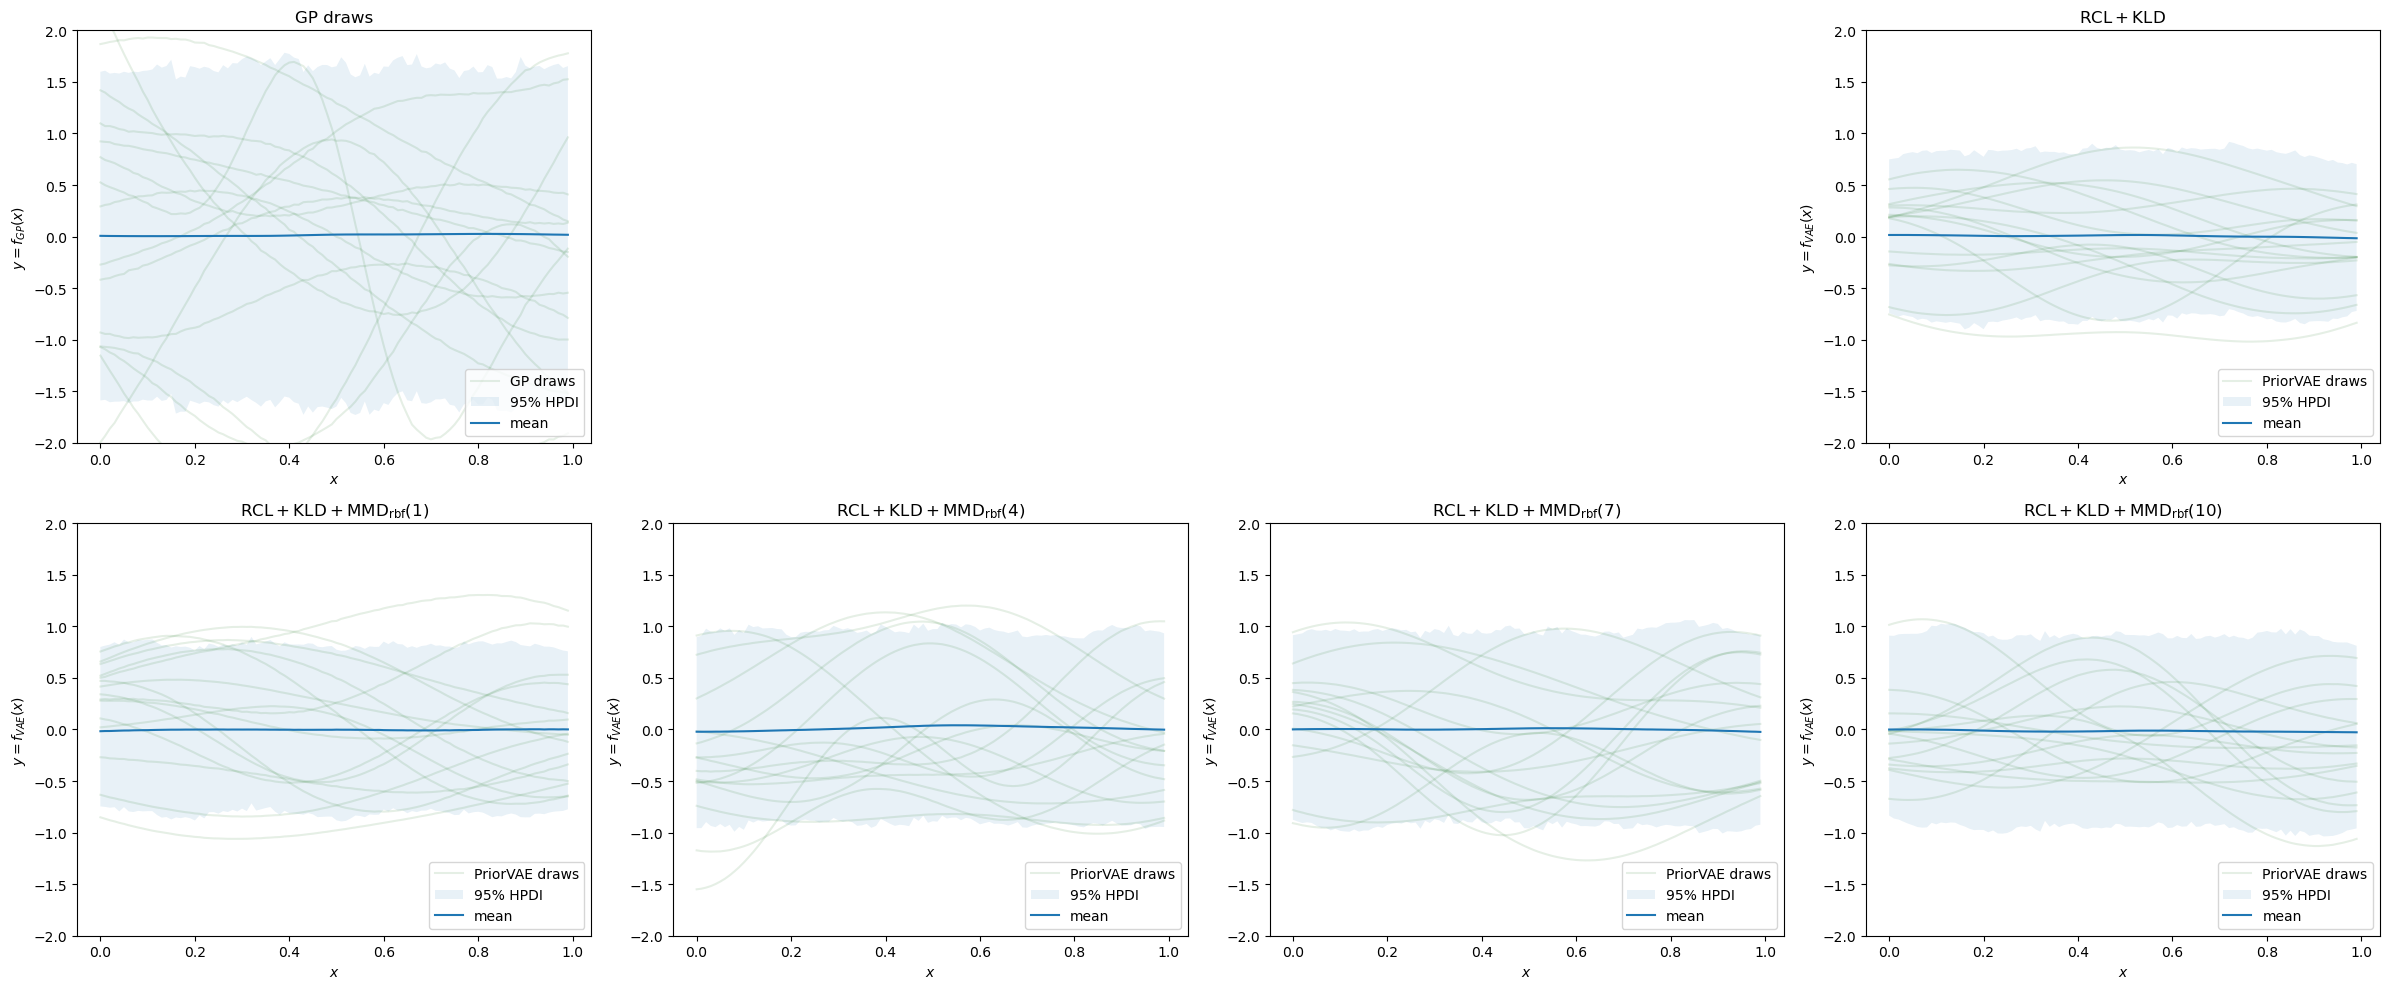

In [9]:
experiment = "exp4"
number = "1" # disambiguate argument files

#show_loss_scores(16, experiment, number)
#plot_training_histories(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")
plot_trained_draws(16, experiment, number, num_cols=4, num_rows=2, backfill="align_right", filter_loss_fns=['RCL+KLD', 'RCL+KLD+mmd_rbf_sum-1.0', 'RCL+KLD+mmd_rbf_sum-4.0', 'RCL+KLD+mmd_rbf_sum-7.0', 'RCL+KLD+mmd_rbf_sum-10.0'])

## Checking some correlation matrices

In [ ]:
from reusable.util import load_args, load_training_state, gen_file_name, get_decoder_params
from reusable.vae import VAE, vae_sample
import optax
from reusable.train_nn import SimpleTrainState
import jax.random as random
import jax.numpy as jnp
from numpyro.infer import Predictive
from reusable.scoring import calc_correlation_mats
from plotting.plots import plot_correlation_grid
from reusable.gp import BuildGP

code = 16
args_disambig = 1
experiment = "exp3"

loss_fn ="0.01RCL+15mmd_rbf_sum-4.0+KLD"

args = load_args(code, args_disambig, experiment)


file_name = gen_file_name(args["expcode"], args, args["experiment"] + loss_fn)

rng_key = random.PRNGKey(2234)
rng_key, rng_key_init1, rng_key_init2 = random.split(rng_key, 3)
gp = BuildGP(
    args["gp_kernel"],
    noise=False,
    length_prior_choice=args["length_prior_choice"],
    prior_args=args["length_prior_arguments"],
)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
)
params = module.init(rng_key_init1, jnp.ones((args["n"],)))["params"]
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init2)


final_state = load_training_state(args["expcode"], file_name, state, arc_learnt_models_dir=False)


rng_key, rng_key_gp, rng_key_vae = random.split(rng_key, 3)

print("Drawing from GP", flush=True)

gp_predictive = Predictive(gp, num_samples=10000)
gp_draws = gp_predictive(rng_key_gp, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]

print("Drawing from VAE", flush=True)

plot_vae_predictive = Predictive(vae_sample, num_samples=10000)
vae_draws = plot_vae_predictive(
    rng_key_vae,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=get_decoder_params(final_state),
)["f"]

plot_correlation_grid(gp_draws, vae_draws, [1,2,3,4])
